## StatQuest!
# XGBoost in Python, From Start to Finish (Credit Default)
Copyright 2020, Joshua Starmer

----

In this lesson we will use **XGBoost** to build a collection of boosted trees (one of which is illustrated below), and use continuous and categorical data from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)** to predict whether or not a person will **[default on their credit card](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)**.

<!-- <img src="./xgboost_tree.png" alt="An XGBoost Tree" style="width: 600px;"> -->
<img src="./xgboost_tree_credit_card.png" alt="An XGBoost Tree" style="width: 1200px;">

**XGBoost** is an exceptionally useful machine learning method when you don't want to sacrifice the ability to correctly classify observations but you still want a model that is fairly easy to understand and interpret. 

In this lesson you will learn about...

- **[Importing Data from a File](#download-the-data)**

- **[Missing Data](#identify-and-deal-with-missing-data)**
    - Identifying Missing Data
    - Dealing with Missing Data
    

- **[Formatting the Data for XGBoost](#format-the-data)**

    - Splitting data into Dependent and Independent Variables
    - One-Hot-Encoding
    - Converting all columns to Int, Float or Bool
    

- **[Building a Preliminary XGBoost Model](#build-tree)**


- **[Optimizing Parameters with Cross Validation and GridSearch()](#optimize-parameters)**
    
    - Optimizing the learning rate, tree depth, number of trees, gamma (for pruning) and lambda (for regularization).


- **[Building, Drawing, Interpreting and Evaluating the Optimized XGBoost Model](#draw-tree)**

#### NOTE:
This tutorial assumes that you already know the basics of coding in **Python** and are familiar with the theory behind **[XGBoost](https://youtu.be/OtD8wVaFm6E)**, **[Cross Validation](https://youtu.be/fSytzGwwBVw)** and **[Confusion Matrices](https://youtu.be/Kdsp6soqA7o)**. If not, check out the **StatQuests** by clicking on the links for each topic.


#### Also Note:
I strongly encourage you to play around with the code. Playing with the code is the best way to learn from it.

-----

# Import the modules that will do all the work
The very first thing we do is load in a bunch of python modules. Python, itself, just gives us a basic programming language. These modules give us extra functionality to import the data, clean it up and format it, and then build, evaluate and draw the **XGBoost** model. 

**NOTE:** You will need **Python 3** and have at least these versions for each of the following modules: 
- pandas >= 1.2.3
- numpy >= 1.19.2
- sklearn >= 0.24.1
- xgboost >= 1.3.3
 
If you installed **Python 3** with [Anaconda](https://www.anaconda.com/), you can check which versions you have with the command: `conda list`. If, for example, your version of `scikit-learn` is older than 0.22.1, then the easiest thing to do is just update all of your **Anaconda** packages with the following command: `conda update --all`. However, if you only want to update `scikit-learn`, then you can run this command: `conda install scikit-learn=0.22.1`.

If you need to install `xgboost`, then you can do so with the following command: `conda install -c conda-forge xgboost`.

**NOTE:** To draw the tree, you will also need to install `graphviz`. You can do that with the command: `conda install graphviz python-graphviz`.

In [2]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

----

<a id="download-the-data"></a>
# Import the data
Now we load in a dataset from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**.
Specifically, we are going to use the **[Credit Card Default](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)** dataset. This dataset will allow us to predict if someone will default on their credit card payments based on their sex, age and a variety of other metrics.

**NOTE:** When **pandas** (**pd**) reads in data, it returns a **data frame**, which is a lot like a spreadsheet. The data are organized in rows and columns and each row can contain a mixture of text and numbers. The standard variable name for a **data frame** is the initials **df**, and that is what we will use here:

In [3]:
df = pd.read_csv('default_of_credit_card_clients.tsv', 
                 header=1, ## NOTE: The second line contains column names, so we skip the first line
                 sep='\t') ## NOTE: Pandas automatically detects delimeters, but it never hurts to be specific

## NOTE: We can also read in the original MS Excel file directly from the website
# df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls', 
#                  header=1,
#                  sep='\t')

Now that we have loaded the data into a **data frame** called **df**, let's look at the first five rows using the `head()` function:

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


We see a bunch of columns for the variables collected for each customer. The columns are...
- **ID**, The ID number assigned to each customer
- **LIMIT_BAL**, Credit limit
- **SEX**, Gender
- **EDUCATION**, Level of education
- **MARRIAGE**, Marital status
- **AGE**, Age
- **PAY_**, When the last 6 bills were paid
- **BLL_AMT**, What the last 6 bills were
- **PAY_AMT**, How much the last payments were
- **default payment next month**

**NOTE:** The last column name, **default payment next month**, is long. Let's change it to **default**...

In [5]:
# rename the last column name

df.rename({'default payment next month' : 'DEFAULT'}, axis='columns', inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Also, the values in the **ID** column were randomly assigned, making it uninformative, so we can drop it...

In [6]:
# Drop ID column

df.drop('ID', axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
# check the overall information about this dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

Hooray! We cleaned up the columns a little bit. Now that we have the data in a **data frame** called **df**, we are ready to identify and deal with **Missing Data**.


----

<a id="identify-and-deal-with-missing-data"></a>
# Missing Data Part 1: Identifying Missing Data

Unfortunately, the biggest part of any data analysis project is making sure that the data is correctly formatted and fixing it when it is not. The first part of this process is identifying **Missing Data**.

**Missing Data** is simply a blank space, or a surrogate value like **NA**, that indicates that we failed to collect data for one of the features. For example, if we forgot to ask someone's age, or forgot to write it down, then we would have a blank space in the dataset for that person's **age**.

One thing that is relatively unique about **XGBoost** is that it has default behavior for missing data. So all we have to do is identify missing values and make sure they are set to `0`.

In this section, we'll focus on identifying missing values in the dataset. 

First, let's see what sort of data is in each column.

In [8]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

We see that every column is `int64`, this is good, since it tells us that they did not mix letters and numbers. In other words, there are no **NA** values, or other character based place holders for missing data, in **df**.

That said, we should still make sure each column contains acceptable values. The list below describes what values are allowed
in each column and was based on the column descriptions on the **[Credit Card Default](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)** webpage.

- **LIMIT_BAL**, The amount of available credit **Integer**
- **SEX**, **Category**
  - 1 = male
  - 2 = female
- **EDUCATION**, **Category**
  - 1 = graduate school
  - 2 = university
  - 3 = high school
  - 4 = others
- **MARRIAGE**, **Category**
  - 1 = Married
  - 2 = Single
  - 3 = Other
- **AGE**, **Integer**
- **PAY_**, When the last 6 bills were paid **Category**
  - -1 = Paid on time
  - 1 = Payment delayed by 1 month
  - 2 = Payment delayed by 2 months
  - ...
  - 8 = Payment delayed by 8 months
  - 9 = Payment delayed by 9 or more months
- **BILL_AMT**, What the last 6 bills were **Integer**
- **PAY_AMT**, How much the last payments were **Integer**
- **DEFAULT**, Whether or not a person defaulted on the next payment **CATEGORY**
  - 0 = Did not default
  - 1 = Defaulted

Let's start by making sure **SEX** only contains the numbers 1 and 2.

In [9]:
df['SEX'].unique()

array([2, 1], dtype=int64)

**BAM!** It does. Now let's look at **Education** and make sure it only contains 1, 2, 3, and 4.

In [10]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

So, for reasons unknown, in addition to the allowed numbers, 1, 2, 3, and 4, **EDUCATION** also contains 0, 5 and 6. It is possible that 0 represents missing data and 5 and 6 represent categories not mentioned in the specification, but that is just a guess.

Now let's look at **MARRIAGE** and make sure it only contains 1, 2, 3.

In [11]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0], dtype=int64)

Like **EDUCATION**, **MARRIAGE** contains **0**, which I'm guessing represents missing data.

**NOTE:** This dataset is part of an academic publication that *is not* open access and is owned by **Elsevier**. So, in theory, I could pay a lot of money to get the article about this dataset and find out if **0** represents missing data or not. But since this is a demo, we won't worry too much about being correct and see what happens when we treat **0** as missing data.
**NOTE:** I tried both ways and the model performs better when we treat **0** as missing data.

Now that we have identified some potential missing values, we need to deal with them.


----


# Missing Data Part 2: Dealing With Missing Data, XGBoost Style

One thing that is relatively unique about **XGBoost** is that it determines default behavior for missing data. So all we have to do is identify missing values and make sure they are set to `0`.

However, before we do that, let's see how many rows are missing data. If it's a lot, then we might have a problem on our hands that is bigger than what **XGBoost** can deal with on its own. If it's not that many, we can just set them to `0`.

In [12]:
len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)])

68

So, only **68** rows have missing values. Now let's count the total number of rows in the dataset...

In [13]:
len(df)

30000

So **68** of the **30,000** rows, or less than **1%**, contain missing values. Since this is a relatively small amount of data, and since the data already uses `0` to represent missing values, we are done dealing with missing data.

**NOTE** If the dataset uses `NA` or `?` to represent missing data, we would simply set those values to `0` and be done.

----

<a id="format-the-data"></a>
# Format Data Part 1: Split the Data into Dependent and Independent Variables

Now that we have taken care of the missing data, we are ready to start formatting the data for making an **XGBoost** model.

The first step is to split the data into two parts:
1. The columns of data that we will use to make classifications
2. The column of data that we want to predict.

We will use the conventional notation of `X` (capital **X**) to represent the columns of data that we will use to make classifications and `y` (lower case **y**) to represent the thing we want to predict. In this case, we want to predict **DEFAULT** (whether or not someone defaulted on a payment)..

The reason we deal with missing data before splitting it into **X** and **y** is that if we remove rows, splitting after ensures that each row in **X** correctly corresponds with the appropriate value in **y**.

**NOTE:** In the code below we are using `copy()` to copy the data *by value*. By default, pandas uses copy *by reference*. Using `copy()` ensures that the original data `df_no_missing` is not modified when we modify `X` or `y`. In other words, if we make a mistake when we are formatting the columns for classification trees, we can just re-copy `df_no_missing`, rather than have to reload the original data and  remove the missing values etc.

In [14]:
X = df.drop('DEFAULT', axis=1).copy() # alternatively: X = df_no_missing.iloc[:,:-1]
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [15]:
y = df['DEFAULT'].copy()
y.head()

0    1
1    1
2    0
3    0
4    0
Name: DEFAULT, dtype: int64

Now that we have created **X**, which has the data we want to use to make predictions, and **y**, which has the data we want to predict, we are ready to continue formatting **X** so that it is suitable for making a model with **XGBoost**.

----

<a id="one-hot-encoding"></a>
# Format the Data Part 2: One-Hot Encoding

Now that we have split the data frame into two pieces, `X`, which contains the data we will use to make, or predict, classifications, and `y`, which contains the known classifications in our training dataset, we need to take a closer look at the variables in `X`. The list below tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

- **LIMIT_BAL**, The amount of available credit **Integer**
- **SEX**, **Category**
  - 1 = male
  - 2 = female
- **EDUCATION**, **Category**
  - 1 = graduate school
  - 2 = university
  - 3 = high school
  - 4 = others
- **MARRIAGE**, **Category**
  - 1 = Married
  - 2 = Single
  - 3 = Other
- **AGE**, **Integer**
- **PAY_**, When the last 6 bills were payed **Category**
  - -1 = Paid on time
  - 1 = Payment delayed by 1 month
  - 2 = Payment delayed by 2 months
  - ...
  - 8 = Payment delayed by 8 months
  - 9 = Payment delayed by 9 or more months
- **BILL_AMT**, What the last 6 bills were **Integer**
- **PAY_AMT**, How much the last payments were **Integer**
- **DEFAULT**, Whether or not a person defaulted on the next payment **CATEGORY**
  - 0 = Did not default
  - 1 = Defaulted
  
Now, just to review, let's look at the data types in `X` to remember how python is seeing the data right now.

In [16]:
X.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
dtype: object

So it looks like **SEX**, **EDUCATION**, **MARRIAGE** and **PAY_** are supposed to be categorical and need to be modified. This is because, while **scikit learn Support Vector Machines** natively support continuous data, like **LIMIT_BAL** and **AGE**, they do not natively support categorical data, like **MARRIAGE**, which contains **3** different categories. Thus, in order to use categorical data with **scikit learn Support Vector Machines**, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called **One-Hot Encoding**.

At this point you may be wondering, "what's wrong with treating categorical data like continuous data?" To answer that question, let's look at an example: For the **MARRIAGE** column, we have 3 options:
1. Married
2. Single
3. Other

If we treated these values, 1, 2, and 3, like continuous data, then we would assume that 3, which means "Other", is more similar to 2, which means "Single", than it is to 1, which means "Married". That means the support vector machine would be more likely to cluster the people with 3s and 2s together than the people with 3s and 1s together. In contrast, if we treat these numbers like categorical data, then we treat each one as a separate category that is no more or less similar to any of the other categories. Thus, the likelihood of clustering people with 3s with 2s is the same as clustering 3s with 1s, and that approach is more reasonable.

**NOTE:** There are many different ways to do **One-Hot Encoding** in Python. Two of the more popular methods are `ColumnTransformer()` (from **scikit-learn**) and `get_dummies()` (from **pandas**), and both methods have pros and cons. `ColumnTransformer()` has a very cool feature where it creates a persistent function that can validate data that you get in the future. For example, if you build your **Support Vector Machine** using a categorical variable **favorite color** that has **red**, **blue** and **green** options, then `ColumnTransformer()` can remember those options and later on when your **Support Vector Machine** is being used in a production system, if someone says their favorite color is **orange**, then `ColumnTransformer()` can throw an error or handle the situation in some other nice way. The downside of `ColumnTransformer()` is that it turns your data into an array and loses all of the column names, making it harder to verify that your usage of `ColumnTransformer()` worked as you intended it to. In contrast, `get_dummies()` leaves your data in a dataframe and retains the column names, making it much easier to verify that it worked as intended. However, it does not have the persistent behavior that `ColumnTransformer()` has. So, for the sake of learning how **One-Hot Encoding** works, I prefer to use `get_dummies()`. However, once you are comfortable with **One-Hot Encoding**, I encourage you to investigate using `ColumnTransformer()`.

First, before we commit to converting columns with **One-Hot Encoding**, let's just see what happens when we convert **MARRIAGE** without saving the results. This will make it easy to see how `get_dummies()` works.

In [17]:
pd.get_dummies(X, columns=['MARRIAGE']).head()

,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000,2,2,24,2,2,-1,-1,-2,-2,...,0,689,0,0,0,0,0,1,0,0
1,120000,2,2,26,-1,2,0,0,0,2,...,0,1000,1000,1000,0,2000,0,0,1,0
2,90000,2,2,34,0,0,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,0,1,0
3,50000,2,2,37,0,0,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,1,0,0
4,50000,1,2,57,-1,0,-1,0,0,0,...,2000,36681,10000,9000,689,679,0,1,0,0


As we can see in the printout above, `get_dummies()` puts all of the columns it does not process on the left side and it puts **MARRIAGE** on the right side. It also splits **MARRIAGE** into **3** columns, just like we expected. **MARRIAGE_1** is `1` for any person that had a **1** for **MARRIAGE** and `0` for all other customers. **MARRIAGE_2** is `1` for anyone that had a **2** for **MARRIAGE** and `0` for all other customers. Lastly, **MARRIAGE_3** is `1` for anyone with a **3** for **MARRIAGE** and `0` for all other customers..

Now that we see how `get_dummies()` works, let's use it on the categorical columns and save the result.

**NOTE:** In a real situation (not a tutorial like this), you should verify all 5 of these columns to make sure they 
only contain the accepted categories.

In [18]:
X_encoded = pd.get_dummies(X, columns=['SEX',
                                       'EDUCATION',
                                       'MARRIAGE', 
                                       'PAY_0',
                                       'PAY_2',
                                       'PAY_3',
                                       'PAY_4',
                                       'PAY_5',
                                       'PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,0,1,0,0,0,0,0,0,0


# Double BAM!!!

-----

<a id="one-hot-encoding"></a>
# Format the Data Part 3: Convert all columns to Int, Float or Bool

**XGBoost** requires that all data be either `int`, `float` or `boolean` data types. We can use `dtypes` to see if there are any columns that need to be converted...

In [19]:
X_encoded.dtypes

LIMIT_BAL    int64
AGE          int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
             ...  
PAY_6_4      uint8
PAY_6_5      uint8
PAY_6_6      uint8
PAY_6_7      uint8
PAY_6_8      uint8
Length: 91, dtype: object

...and we see that we have more columns than we can print on the screen. No problem, we can just print out the unique values for dtype...

In [20]:
X_encoded.dtypes.unique()

array([dtype('int64'), dtype('uint8')], dtype=object)

...and we see that everything is one type of integer or another, so we are set for **XGBoost**.

Now let's double check `y` and make sure it is either `float`, `int` or `boolean`.

In [21]:
y.dtypes

dtype('int64')

# Double BAM!!!

We have finally finished formatting the data for making an **XGBoost** model, so let's do it!!!



----

<a id="build-tree"></a>
# Build A Preliminary XGBoost Model
At long last, the data is correctly formatted for making an **XGBoost** model. Now we simply split the data into **training** and **testing** sets and build the model. However, first, let's observe that this data is imbalanced by dividing the number of people who defaulted, where `y = 1`, by the total number of people in the dataset. 

In [22]:
sum(y)/len(y)

0.2212

So we see that only 22% of the people in the dataset defaulted. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who defaulted in both the **training** set and the **testing** set.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

Now let's verify that using `stratify` worked as expected...

In [24]:
sum(y_train)/len(y_train)

0.2212

In [25]:
sum(y_test)/len(y_test)

0.2212

**BAM!!!** `stratify` worked as expected and both `y_train` and `y_test` have the same percentage of people that defaulted. Now let's build the preliminary model.

In [26]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            eval_metric="logloss", ## this avoids a warning...
                            seed=42,
                            use_label_encoder=False)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

OK, we've built an **XGBoost** model for classification. Let's see how it performs on the **Testing Dataset** by running the **Testing Dataset** down the model and drawing a **Confusion Matrix**.

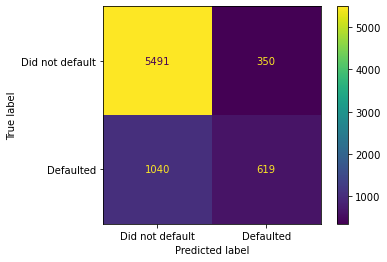

In [31]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Did not default", "Defaulted"])

In the confusion matrix, we see that of the **5841** people that did not default, **5491 (94%)** were correctly classified. So that's good. However, of the **1659** people that defaulted, only **619 (37%)** were correctly classified. So the **XGBoost** model was not awesome. Part of the problem is that our data is imbalanced, which we saw earlier and we see this in the confusion matrix with the top row showing **5841** people that did not default and the bottom row showing **1659** people who did. Because defaulting on loans costs the company a lot of money, we would like to capture more of the people that defaulted. The good news is that **XGBoost** has a parameter that helps with imbalanced data, So let's try to improve predictions using **Cross Validation** to optimize the parameters.

----

<a id="optimize-parameters"></a>
# Optimize Parameters using Cross Validation and GridSearch()

**XGBoost** has a lot of *hyperparameters*, parameters that we have to manual configure and are not determined by XGBoost itself, including `max_depth`, the maximum tree depth, `learning_rate`, the learning rate, or "eta", `gamma`, the parameter that encourages pruning, `reg_lambda`, the regularization parameter lambda and `scale_pos_weight`, which helps with imbalanced datasets. So let's try to find the optimal values for these hyperparameters in hopes that we can improve the accuracy with the **Testing Dataset**.

**NOTE:** Since we have many hyperparameters to optimize, we will use `GridSearchCV()`. We specify a bunch of potential values for the hyperparameters and `GridSearchCV()` tests all possible combinations of the parameters for us.

**ALSO NOTE:** Instead of determining the optimal number of trees with cross validation, we will use **early stopping** to stop building trees when they no longer improve the situation.

In [ ]:
# ## NOTE: When data are imbalanced, the XGBoost manual says...
# ## If you care only about the overall performance metric (AUC) of your prediction
# ##     * Balance the positive and negative weights via scale_pos_weight
# ##     * Use AUC for evaluation
# ## ALSO NOTE: I ran GridSearchCV sequentially on subsets of parameter options, rather than all at once
# ## in order to optimize parameters in a short period of time.

# ## ROUND 1
# # param_grid = {
# #     'max_depth': [3, 4, 5],
# #     'learning_rate': [0.1, 0.01, 0.05],
# #     'gamma': [0, 0.25, 1.0],
# #     'reg_lambda': [0, 1.0, 10.0],
# #     'scale_pos_weight': [1, 3, 5] # NOTE: XGBoost recommends sum(negative instances) / sum(positive instances)
# # }
# ## Output: max_depth: 5, learning_rate: 0.1, gamma: 0, reg_lambda: 10, scale_pos_weight: 3
# ## Because max_depth, learning_rate and reg_lambda were at the ends of their range, we will continue to explore those...

# ## ROUND 2
# # param_grid = {
# #     'max_depth': [5, 6, 7],
# #     'learning_rate': [0.1, 0.5, 1],
# #     'gamma': [0],
# #     'reg_lambda': [10.0, 20, 100],
# #      'scale_pos_weight': [3]
# # }
# ## Output: max_depth: 6, learning_rate: 0.1, reg_lambda: 100. Because reg_lambda was a the end, we will continue to explore

# ## Round 3
# param_grid = {
#     'max_depth': [6],
#     'learning_rate': [0.1],
#     'gamma': [0],
#     'reg_lambda': [100, 500, 1000],
#     'scale_pos_weight': [3]
# }

# ## NOTE: To speed up cross validiation, and to further prevent overfitting.
# ## We are only using a random subset of the data (90%) and are only
# ## using a random subset of the features (columns) (50%) per tree.
# optimal_params = GridSearchCV(
#     estimator=xgb.XGBClassifier(objective='binary:logistic', 
#                                 seed=42,
#                                 subsample=0.9,
#                                 colsample_bytree=0.5,
#                                 use_label_encoder=False),
#     param_grid=param_grid,
#     scoring='roc_auc', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#     verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
#     n_jobs = 10,
#     cv = 3
# )

# optimal_params.fit(X_train, 
#                    y_train, 
#                    early_stopping_rounds=10,                
#                    eval_metric='auc',
#                    eval_set=[(X_test, y_test)],
#                    verbose=False)
# print(optimal_params.best_params_)

So, after testing all possible combinations of the potential parameter values with **Cross Validation**, we see that we should set `gamma=0`, `learning_rate=0.1`, `max_depth=6`, `reg_lambda=500` and `scale_pos_weight=3`.

----

<a id="draw-tree"></a>
# Building, Evaluating, Drawing, and Interpreting the Optimized XGBoost Model

Now that we have the ideal parameter values, we can build the final **XGBoost** model:

In [33]:
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        gamma=0,
                        learning_rate=0.1,
                        max_depth=6,
                        reg_lambda=500,
                        scale_pos_weight=3,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        use_label_encoder=False)

# For imbalanced datasets, a more appropriate evaluation metric is the area under the precision-recall curve, 
# so set eval_metric="aucpr" instead.

clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.44314
[1]	validation_0-aucpr:0.45582
[2]	validation_0-aucpr:0.47014
[3]	validation_0-aucpr:0.49543
[4]	validation_0-aucpr:0.50604
[5]	validation_0-aucpr:0.51100
[6]	validation_0-aucpr:0.50913
[7]	validation_0-aucpr:0.51202
[8]	validation_0-aucpr:0.51062
[9]	validation_0-aucpr:0.51498
[10]	validation_0-aucpr:0.51541
[11]	validation_0-aucpr:0.51724
[12]	validation_0-aucpr:0.51924
[13]	validation_0-aucpr:0.51981
[14]	validation_0-aucpr:0.52134
[15]	validation_0-aucpr:0.52174
[16]	validation_0-aucpr:0.52228
[17]	validation_0-aucpr:0.52132
[18]	validation_0-aucpr:0.52200
[19]	validation_0-aucpr:0.52307
[20]	validation_0-aucpr:0.52378
[21]	validation_0-aucpr:0.52367
[22]	validation_0-aucpr:0.52368
[23]	validation_0-aucpr:0.52729
[24]	validation_0-aucpr:0.52720
[25]	validation_0-aucpr:0.52796
[26]	validation_0-aucpr:0.52786
[27]	validation_0-aucpr:0.52770
[28]	validation_0-aucpr:0.52814
[29]	validation_0-aucpr:0.52791
[30]	validation_0-aucpr:0.52785
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=24, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=500,
              scale_pos_weight=3, seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

Now let's draw another confusion matrix to see if the optimized **XGBoost** model does better.

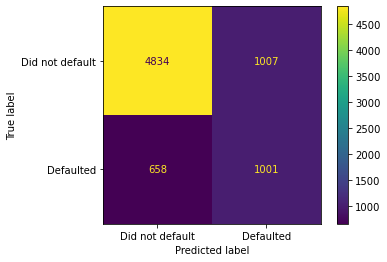

In [34]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test, 
                      values_format='d',
                      display_labels=["Did not default", "Defaulted"])

We see that the optimized **XGBoost** model is now almost twice as good at correctly classifying people that defaulted. This was at the expense of incorrectly classifying people that did not default, and this tradeoff is something that the company might have to think about. However, from our perspective, this was a success.

The last thing we are going to do is draw the first **XGBoost Tree** and discuss how to interpret it.

In [36]:
## If we want to get information, like gain and cover etc, at each node in the first tree, 
## we just build the first tree, otherwise we'll get the average over all of the trees.

clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            eval_metric="logloss", ## this avoids a warning...
                            gamma=0,
                            learning_rate=0.1,
                            max_depth=6,
                            reg_lambda=500,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            n_estimators=1, ## We set this to 1 so we can get gain, cover etc.
                            use_label_encoder=False
                            )
clf_xgb.fit(X_train, y_train)

## now print out the weight, gain, cover etc. for the tree
## weight = number of times a feature is used in a branch or root across all trees
## gain = the average gain across all splits that the feature is used in
## cover = the average coverage across all splits a feature is used in
## total_gain = the total gain across all splits the feature is used in
## total_cover = the total coverage across all splits the feature is used in
## NOTE: Since we only built one tree, gain = total_gain and cover=total_cover
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', ## make the nodes fancy
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'} 
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}
## NOTE: num_trees is NOT the number of trees to plot, but the specific tree you want to plot
## The default value is 0, but I'm setting it just to show it in action since it is
## counter-intuitive.
xgb.to_graphviz(clf_xgb, num_trees=0, 
                condition_node_params=node_params,
                leaf_node_params=leaf_params)
## if you want to save the figure...

# graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10", 
#                 condition_node_params=node_params,
#                leaf_node_params=leaf_params) 
    
# graph_data.view(filename='xgboost_tree_credit_card') ## save as PDF

weight:  {'AGE': 7.0, 'BILL_AMT1': 8.0, 'BILL_AMT2': 4.0, 'BILL_AMT5': 3.0, 'BILL_AMT6': 3.0, 'PAY_AMT1': 7.0, 'PAY_AMT6': 4.0, 'EDUCATION_1': 1.0, 'EDUCATION_5': 1.0, 'PAY_0_0': 1.0, 'PAY_2_2': 1.0, 'PAY_3_0': 2.0, 'PAY_3_2': 2.0, 'PAY_3_3': 2.0, 'PAY_4_-1': 1.0, 'PAY_6_-1': 1.0, 'PAY_6_3': 1.0}
gain:  {'AGE': 0.34006085991859436, 'BILL_AMT1': 13.622907638549805, 'BILL_AMT2': 11.670642852783203, 'BILL_AMT5': 0.5631714463233948, 'BILL_AMT6': 0.5251995921134949, 'PAY_AMT1': 31.246877670288086, 'PAY_AMT6': 1.2212330102920532, 'EDUCATION_1': 1.4668729305267334, 'EDUCATION_5': 7.8929443359375, 'PAY_0_0': 457.041748046875, 'PAY_2_2': 2525.772705078125, 'PAY_3_0': 139.60693359375, 'PAY_3_2': 135.58876037597656, 'PAY_3_3': 21.806259155273438, 'PAY_4_-1': 0.015928421169519424, 'PAY_6_-1': 17.5218505859375, 'PAY_6_3': 8.5081787109375}
cover:  {'AGE': 232.9642791748047, 'BILL_AMT1': 696.46875, 'BILL_AMT2': 343.1875, 'BILL_AMT5': 34.41666793823242, 'BILL_AMT6': 60.83333206176758, 'PAY_AMT1': 454.

'xgboost_tree_credit_card.pdf'

Now let's discuss how to interpret the **XGBoost Tree**.
In each node, we have:
- The variable (column name) and the threshold for splitting the observations. For example, in the tree's root, we use **PAY_0_2** to split the observations. All observations with **PAY_0_2 < 1** go to the **left** and all observations with **PAY_0_2 =< 1** go to the **right**.
- Each branch either says **yes** or **no** and some also say **missing**. 
 - **yes** and **no** refer to whether the threshold in the node above it is true or not. If so, then **yes**, if not, then **no**. 
 - **missing** is the default option if there is missing data.
- **leaf** tells us the output value for each leaf.

-----

# In conclusion we...

- **[Loaded the Data From a File](#download-the-data)**

- **[Identified and Dealt with Missing Data](#identify-and-deal-with-missing-data)**

- **[Formatted the Data for XGBoost using One-Hot Encoding](#one-hot-encoding)**

- **[Built an XGBoost Model for Classification](#build-tree)**

- **[Optimize the XGBoost Parameters with Cross Validation and GridSearch()](#prune-tree)**

- **[Built, Drew, Interpreted and Evaluated the Optimized XGBoost Model](#draw-tree)**

# TRIPLE BAM!!!